In [ ]:
!pip install pystan #最初だけ実行(2回目以降は不要)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import stan
import arviz
import nest_asyncio
nest_asyncio.apply()

# ロジスティックモデルのパラメータ推定

## 擬似データの作成

In [4]:
#ロジスティックモデル (擬似データ生成用)
def logistic_model(N,r,K):
  dNdt = r*N*(1-N/K)
  return (dNdt)

def solve_logistic_model(N0,r,K,dt,t_end,sampling_span):
  #初期化
  t = 0
  N = N0
  t_list = [0]
  N_list = [N]

  #オイラー法
  for i in range(int(t_end/dt)):
    t = dt*(i+1)
    dNdt= logistic_model(N,r,K)
    N += dNdt*dt
    if i%sampling_span==0:
      t_list.append(t)
      N_list.append(N)
  return(t_list, N_list)

In [5]:
#微分方程式を解く時の設定
dt = 0.05
t_end = 20
sampling_span = int(1/dt) #データは1/dt時点ごとにサンプリング(dt=0.1なら10ステップに1回サンプリング)

In [54]:
#正解パラメータ
r = 0.5
K = 200
X0 = 20
sigma_x = 20

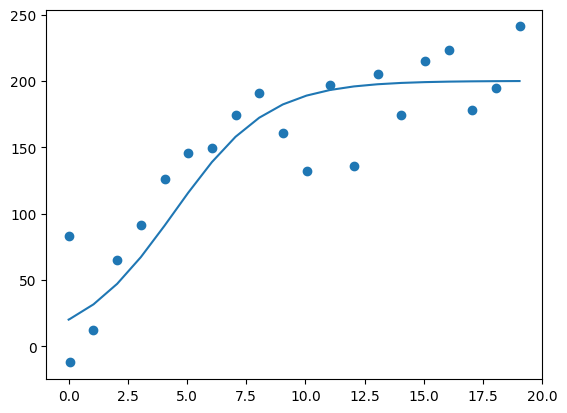

In [55]:
#擬似データ生成
t, x = solve_logistic_model(X0,r,K,dt,t_end,sampling_span)
X = []
for j in range(len(x)):
  X.append(np.random.normal(x[j],sigma_x))
Nt_all = int(t_end/dt)
Nt_sampled = len(t)
sample_span = int(1/dt)

#擬似データの可視化
plt.plot(t,x)
plt.scatter(t,X)
plt.show()

## パラメータ推定

In [65]:
# Stanコード
stan_model = """
functions{
  array [] real solve_logistic_model(real x0, real r, real K, real dt, int Nt_all, int Nt_sampled, int sample_span){
    array[Nt_sampled] real x_list;
    real t;
    real x;
    int j;

    t = 0;
    x = x0;
    j = 1;
    x_list[j] = x;

    for(i in 1:Nt_all){
      x = x + r*x*(1-x/K)*dt;
      if(fmod(i,sample_span)==0){
        j = j + 1;
        x_list[j] = x;
      }
    }
    return x_list;
  }
}

data {
  real dt;
  int Nt_all;
  int Nt_sampled;
  int sample_span;
  array[Nt_sampled] real X_obs;
}

parameters {
  real r;
  real <lower=0>K;
  real <lower=0> x0;
  real <lower=0> sigma_x;
}

model {
  array[Nt_sampled] real x;
  x = solve_logistic_model(x0, r, K, dt, Nt_all, Nt_sampled, sample_span);
  r ~ normal(1,5);
  K ~ normal(100, 100);
  x0 ~ normal(100,100);
  for(j in 1:Nt_sampled){
    X_obs[j] ~ normal(x[j],sigma_x);
  }
}

generated quantities{
  array[Nt_sampled] real X_sim;
  array[Nt_sampled] real x_sim;
  x_sim = solve_logistic_model(x0, r, K, dt, Nt_all, Nt_sampled, sample_span);
  for(i in 1:Nt_sampled){
    X_sim[i] = normal_rng(x_sim[i],sigma_x);
  }
}

"""


In [61]:
#Stanに渡すデータ
stan_data = {
    'dt' : dt,
    'Nt_all' : Nt_all,
    'Nt_sampled' : Nt_sampled,
    'sample_span' : sample_span,
    'X_obs' : X
}

In [62]:
#Stanコードのコンパイル
sm = stan.build(stan_model,data=stan_data)

Building...



Building: 42.2s, done.Messages from stanc:
Warning in '/tmp/httpstan_ikqmw3re/model_cgzosgbh.stan', line 52, column 18: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ikqmw3re/model_cgzosgbh.stan', line 52, column 14: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ikqmw3re/model_cgzosgbh.stan', line 51, column 18: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_ikqmw3re/model_cgzosgbh.stan', line 51, column 13: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later cas

In [63]:
#サンプリング実行(事後分布の乱数を使った計算)
fit = sm.sample(num_chains=4, num_samples=2000, num_warmup = 2000)

Sampling:   0%
Sampling:   1% (100/16000)
Sampling:   1% (200/16000)
Sampling:   3% (500/16000)
Sampling:   5% (800/16000)
Sampling:   8% (1200/16000)
Sampling:  10% (1600/16000)
Sampling:  12% (2000/16000)
Sampling:  15% (2400/16000)
Sampling:  18% (2800/16000)
Sampling:  21% (3300/16000)
Sampling:  36% (5700/16000)
Sampling:  50% (8000/16000)
Sampling:  62% (9900/16000)
Sampling:  62% (10000/16000)
Sampling:  76% (12100/16000)
Sampling: 100% (16000/16000)
Sampling: 100% (16000/16000), done.
Messages received during sampling:
  Gradient evaluation took 0.00017 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00013 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust yo

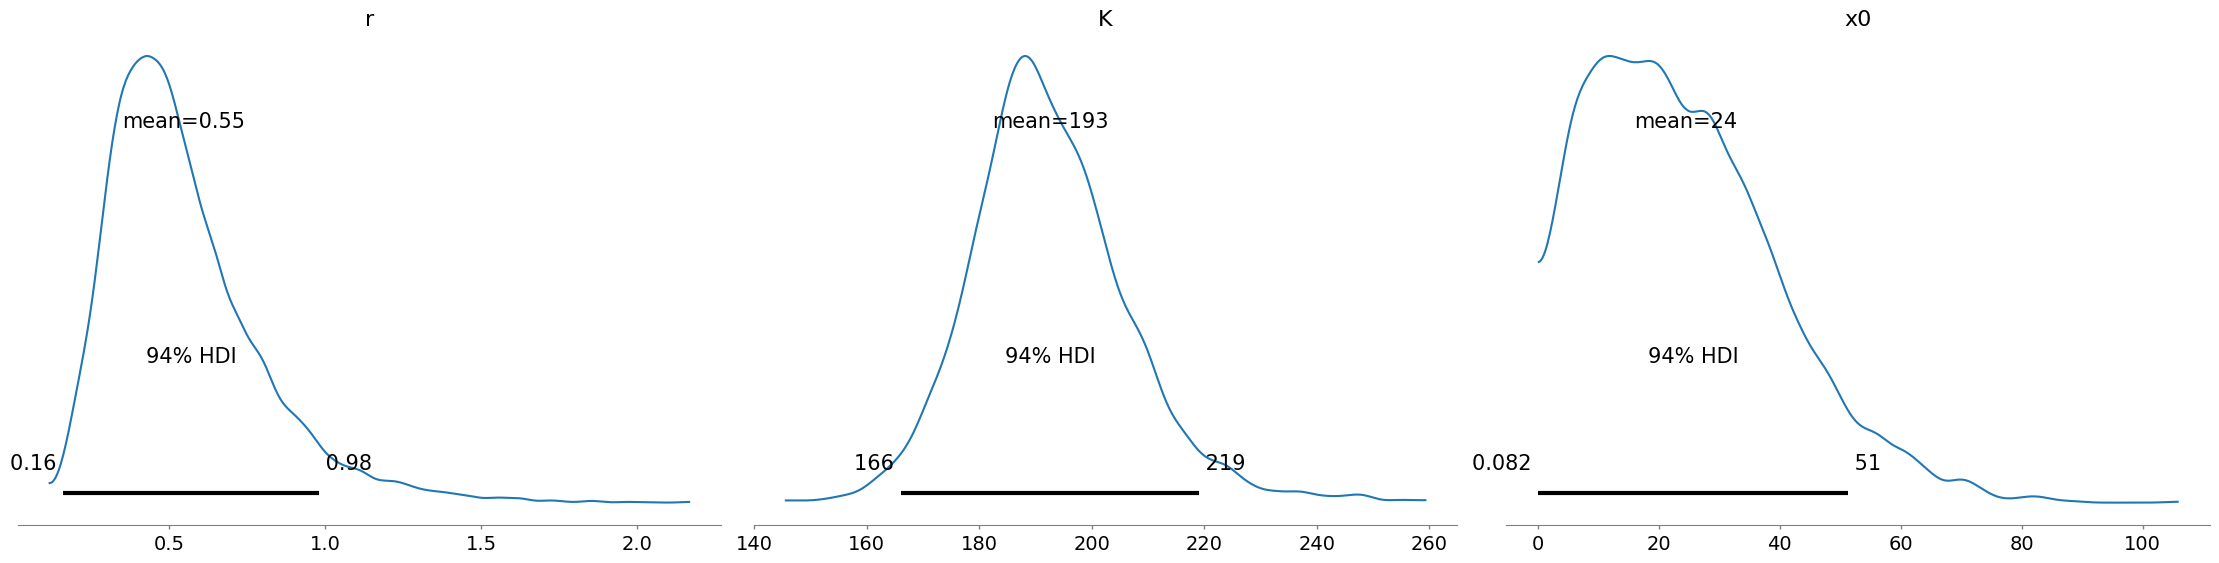

In [64]:
#事後分布の可視化
fig = arviz.plot_posterior(fit, var_names=('r','K','x0'), backend_kwargs={"constrained_layout":True})